Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

import numpy as np

Functions for loading the data

In [2]:
def MNIST_datasets(flat = False, root='./data'):
  # define transformations
  # normalization gives larger range on axis for PCA-plot
  if flat:
    tensor_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,)),
                                           transforms.Lambda(
                                               lambda x: x.view(-1))])
  else:
    tensor_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))])
  # training data set
  train_dataset = torchvision.datasets.MNIST(root=root,
                                              train=True,
                                              download=True,
                                              transform=tensor_transform)

  # test data set
  test_dataset = torchvision.datasets.MNIST(root=root,
                                            train=False,
                                            download=True,
                                            transform=tensor_transform)

  return train_dataset, test_dataset


def getall(dataset):
  dataset_size = len(dataset)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=dataset_size)
  
  return next(iter(data_loader))



def MNIST(test=False):
  # load datasets
  train_dataset, test_dataset = MNIST_datasets()

  if test:
      return getall(test_dataset)
  else:
      return getall(train_dataset)

Functions for training and validation 

In [3]:
def train(net, epochs, trainloader, optimizer, criterion=nn.CrossEntropyLoss(), title=""):
    print('Starting training')

    # need this one here or can pass as argument?
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()


            if i % 200 == 199:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 200))

                running_loss = 0.0
                running_correct = 0.0

    print('Finished training')

def validate(net, testloader):

  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader:      
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      is_correct = (predicted == labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    
  print("Total accuracy of net: %.2f%%" % (correct/total*100))

Function for plotting the encodings

In [4]:
def plot_encoding(train_data, test_data, titles=["training data", "test data"]):


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
  for (data, title, ax) in zip([train_data, test_data], titles, axes.flat):
    encodings, labels = data
    scatter = ax.scatter(encodings[:, 0], encodings[:, 1],
                             c=labels, cmap=plt.cm.tab10, vmin=-0.5,
                             vmax=9.5, alpha=0.7)
                        
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    ax.set_title(title)

  cb = fig.colorbar(scatter, ticks=np.arange(
        0, 10), ax=axes.ravel().tolist())
  cb.ax.set_title("digit")

  plt.show()

In [5]:
def plot_encoding(train_data, test_data, Z=None,
                  annotate=False,
                  titles=["training data", "test data"]):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5)) # was 6

    for (data, title, ax) in zip([train_data, test_data], titles, axes.flat):
        encodings, labels = data
        scatter = ax.scatter(encodings[:, 0], encodings[:, 1],
                             c=labels, cmap=plt.cm.tab10, vmin=-0.5,
                             vmax=9.5, alpha=0.7)
        if Z is not None:
            ax.scatter(Z[:, 0], Z[:, 1], c='black', marker='x')
            if annotate:
                for j in range(Z.size(0)):
                    ax.annotate(j, (Z[j, 0], Z[j, 1]))
                    
        ax.set_xlabel("$z_1$")
        ax.set_ylabel("$z_2$")
        ax.set_title(title)

    cb = fig.colorbar(scatter, ticks=np.arange(
        0, 10), ax=axes.ravel().tolist())
    cb.ax.set_title("digit")

    plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(self.flatten(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
# load datasets

batch_size = 32
train_dataset, test_dataset = MNIST_datasets()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Train CNN on MNIST with learning rate 1e-6  and for one epoch only.



In [9]:
net = Net()
net.to(device)

optimizer = optim.SGD(net.parameters(), lr=1e-6)

train(net, 1, train_loader, optimizer)

Starting training
[1,   200] loss: 2.311
[1,   400] loss: 2.310
[1,   600] loss: 2.311
[1,   800] loss: 2.309
[1,  1000] loss: 2.309
[1,  1200] loss: 2.309
[1,  1400] loss: 2.312
[1,  1600] loss: 2.309
[1,  1800] loss: 2.311
Finished training


In [10]:
validate(net, test_loader)

Total accuracy of net: 10.15%


 Extract the features

In [11]:
all_train_data = getall(train_dataset)
all_test_data = getall(test_dataset)

In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.flatten.register_forward_hook(get_activation('flatten'))

In [13]:
with torch.no_grad():
  train_inputs, train_labels = all_train_data[0].to(device), all_train_data[1].to(device)
  train_outputs = net(train_inputs)
train_activations = activation['flatten']
print(train_activations.shape)

with torch.no_grad():
  test_inputs, test_labels = all_test_data[0].to(device), all_test_data[1].to(device)
  test_outputs = net(test_inputs)
test_activations = activation['flatten']
print(test_activations.shape)


train_activations = train_activations.cpu()
test_activations = test_activations.cpu()
train_labels = train_labels.cpu()
test_labels = test_labels.cpu()

torch.Size([60000, 320])
torch.Size([10000, 320])


Visualization of the features with PCA and TSNE




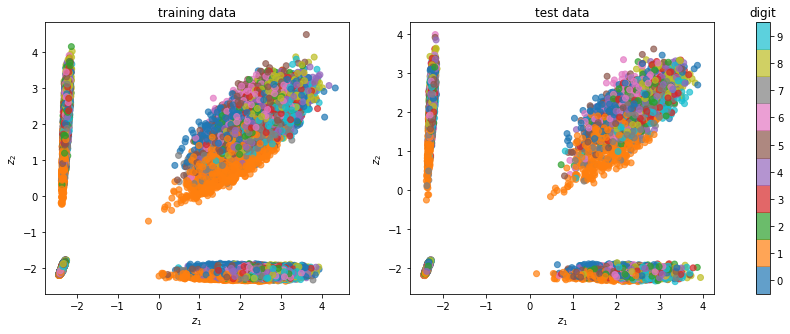

In [16]:
# PCA 
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_activations)

pca_train = pca.transform(train_activations)
pca_test = pca.transform(test_activations)

plot_encoding((pca_train[:,:2], train_labels), (pca_test[:,:2], test_labels))

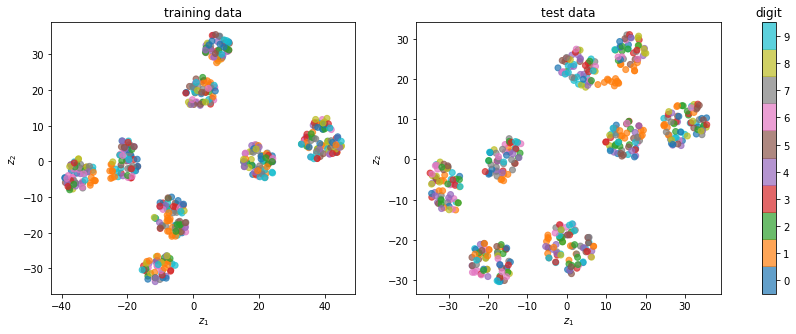

In [18]:
# Use the 10 first principal components
# Don't plot the whole dataset since it takes a lot of time
from sklearn.manifold import TSNE
size = 500
tsne = TSNE(n_components=2, random_state=0)
tsne_train = tsne.fit_transform(pca_train[:size, :10])
tsne_test = tsne.fit_transform(pca_test[:size, :10])

plot_encoding((tsne_train[:,:2], train_labels[:size]), (tsne_test[:,:2], test_labels[:size]))


Train CNN on MNIST with learning rate 1e-6  and for one epoch only.

In [20]:
net = Net()
net.to(device)

#optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

train(net, 10, train_loader, optimizer)

Starting training
[1,   200] loss: 1.303
[1,   400] loss: 0.679
[1,   600] loss: 0.534
[1,   800] loss: 0.448
[1,  1000] loss: 0.408
[1,  1200] loss: 0.366
[1,  1400] loss: 0.335
[1,  1600] loss: 0.324
[1,  1800] loss: 0.286
[2,   200] loss: 0.290
[2,   400] loss: 0.264
[2,   600] loss: 0.239
[2,   800] loss: 0.257
[2,  1000] loss: 0.251
[2,  1200] loss: 0.239
[2,  1400] loss: 0.218
[2,  1600] loss: 0.240
[2,  1800] loss: 0.198
[3,   200] loss: 0.211
[3,   400] loss: 0.203
[3,   600] loss: 0.202
[3,   800] loss: 0.180
[3,  1000] loss: 0.213
[3,  1200] loss: 0.194
[3,  1400] loss: 0.195
[3,  1600] loss: 0.197
[3,  1800] loss: 0.202
[4,   200] loss: 0.184
[4,   400] loss: 0.191
[4,   600] loss: 0.189
[4,   800] loss: 0.183
[4,  1000] loss: 0.178
[4,  1200] loss: 0.176
[4,  1400] loss: 0.175
[4,  1600] loss: 0.174
[4,  1800] loss: 0.170
[5,   200] loss: 0.160
[5,   400] loss: 0.162
[5,   600] loss: 0.188
[5,   800] loss: 0.166
[5,  1000] loss: 0.156
[5,  1200] loss: 0.153
[5,  1400] loss:

In [21]:
validate(net, test_loader)

Total accuracy of net: 96.19%


In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.flatten.register_forward_hook(get_activation('flatten'))


In [23]:
with torch.no_grad():
  train_inputs, train_labels = all_train_data[0].to(device), all_train_data[1].to(device)
  train_outputs = net(train_inputs)
train_activations = activation['flatten']
print(train_activations.shape)

with torch.no_grad():
  test_inputs, test_labels = all_test_data[0].to(device), all_test_data[1].to(device)
  test_outputs = net(test_inputs)
test_activations = activation['flatten']
print(test_activations.shape)

train_activations = train_activations.cpu()
test_activations = test_activations.cpu()
train_labels = train_labels.cpu()
test_labels = test_labels.cpu()

torch.Size([60000, 320])
torch.Size([10000, 320])


Visualization of the features with PCA and TSNE


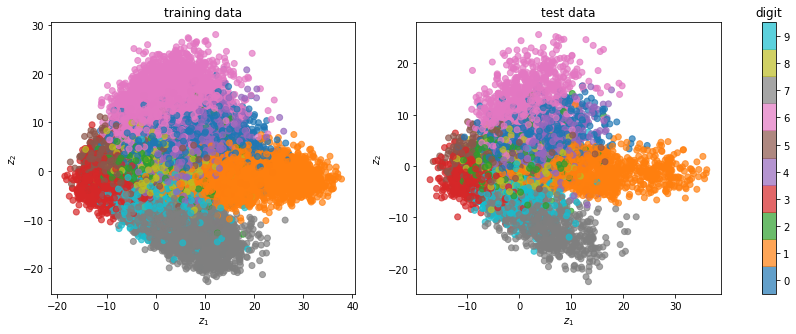

In [24]:
pca = PCA()
pca.fit(train_activations)

pca_train = pca.transform(train_activations)
pca_test = pca.transform(test_activations)

plot_encoding((pca_train[:,:2], train_labels), (pca_test[:,:2], test_labels))

In [25]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
percent_variance[:10]

array([7.7, 5. , 3.8, 3.5, 3. , 2.9, 2.6, 2.4, 2.2, 2. ])

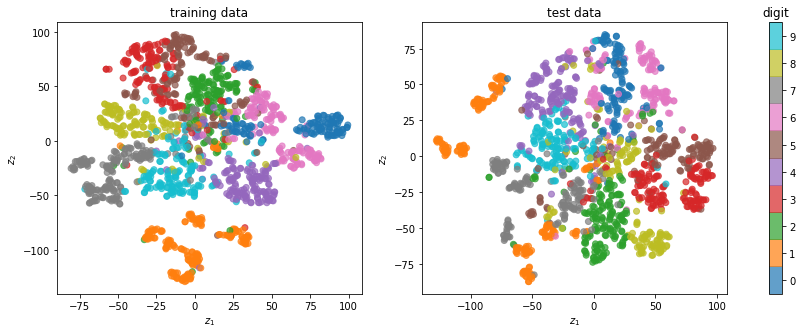

In [26]:
# tsne using the 30 first principal components

size = 1500
tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=2100)
tsne_train = tsne.fit_transform(pca_train[:size, :30])
tsne_test = tsne.fit_transform(pca_test[:size, :30])

plot_encoding((tsne_train[:,:2], train_labels[:size]), (tsne_test[:,:2], test_labels[:size]))

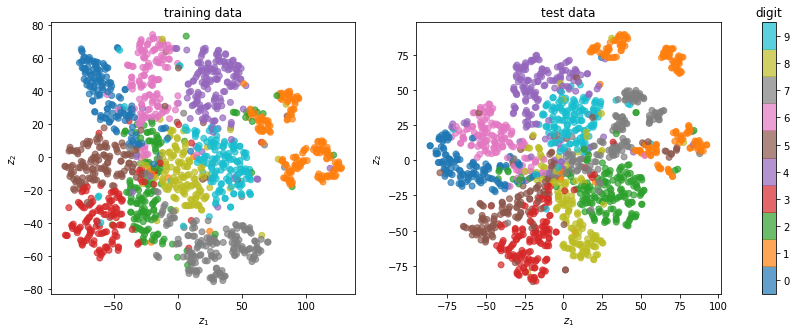

In [27]:
# tsne on activations 

size = 1500
tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=2100)
tsne_train = tsne.fit_transform(train_activations[:size, :])
tsne_test = tsne.fit_transform(test_activations[:size, :])

plot_encoding((tsne_train[:,:2], train_labels[:size]), (tsne_test[:,:2], test_labels[:size]))

In [ ]:
# Get data as 2d 
batch_size = 32
train_dataset, test_dataset = MNIST_datasets(flat = True)
all_train_data = getall(train_dataset)
all_test_data = getall(test_dataset)
train_inputs, train_labels = all_train_data[0], all_train_data[1]
train_inputs.shape

In [27]:
train_inputs[1].shape

torch.Size([784])